# Explore timeseries patterns in cluster groups

In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from src.data import qloader
from quilt.data.elijahc import ripc

from sklearn.manifold import TSNE

import bokeh.plotting as bp
from bokeh.models import ColumnDataSource, Span

## Load plasma mass spec data and join with necessary columns in samples and subjects tables

In [2]:
# Load sample and subject tables
samples = ripc.meta.samples()
subjects = ripc.meta.subjects()

#Load fold change dataset and merge categorical info from samples and subjects
plasma_log2fc = ripc.untargeted.log2fc_plasma()
fc_untargeted = pd.melt(plasma_log2fc.drop(columns=['4J (avg)']), id_vars=['Molecular_Weight'], value_name='log2fc', var_name='sample_id')
fc_untargeted = fc_untargeted.join(samples.query("type == 'Plasma'").set_index('sample_id'), on='sample_id',how='left')
fc_untargeted.Subject = fc_untargeted.Subject.astype(int)
fc_untargeted['min'] = fc_untargeted['min'].astype(int)

In [3]:
fc_untargeted = fc_untargeted.join(subjects.set_index('Subject'), on='Subject')
fc_untargeted.head()

,Molecular_Weight,sample_id,log2fc,Subject,type,timepoint,min,Sex,Height (m),Weight (kg)
0,65.01201,10A,0.0,10,Plasma,A,0,Male,1.96,85.275296
1,65.01261,10A,0.0,10,Plasma,A,0,Male,1.96,85.275296
2,65.01296,10A,0.0,10,Plasma,A,0,Male,1.96,85.275296
3,65.98965,10A,0.0,10,Plasma,A,0,Male,1.96,85.275296
4,65.99026,10A,0.0,10,Plasma,A,0,Male,1.96,85.275296


In [4]:
len(fc_untargeted[['Molecular_Weight']].drop_duplicates())

71738

In [5]:
pop_df = ripc.untargeted.log2fc_plasma_agg_stats()
len(pop_df[pop_df['p-value']<=0.01][['Molecular_Weight']].drop_duplicates())

10803

In [6]:
clust_df = ripc.cluster_segments.isomap_early_0_01_clusters()
clust_df.groupby('cluster_id').count()

,Molecular_Weight,dim_1,dim_2
cluster_id,,,
0,3,3,3
1,10,10,10
2,13,13,13
3,2343,2343,2343
4,165,165,165


In [7]:
clust_ct = clust_df.groupby('cluster_id').count()['dim_1'].values

In [8]:
fc_untargeted['Molecular_Weight_4']=np.round(fc_untargeted.Molecular_Weight.values,decimals=4)
clust_df['Molecular_Weight_4'] = np.round(clust_df.Molecular_Weight.values,decimals=4)
subset = fc_untargeted.Molecular_Weight_4.isin(clust_df.Molecular_Weight_4.values)

In [9]:
fc_subset = fc_untargeted[subset].drop(columns=['Molecular_Weight']).drop_duplicates().join(clust_df.set_index('Molecular_Weight_4'),on='Molecular_Weight_4')
fc_subset.head()


,sample_id,log2fc,Subject,type,timepoint,min,Sex,Height (m),Weight (kg),Molecular_Weight_4,Molecular_Weight,dim_1,dim_2,cluster_id
78,10A,0.0,10,Plasma,A,0,Male,1.96,85.275296,67.9874,67.98743,0.565927,0.024607,3
111,10A,0.0,10,Plasma,A,0,Male,1.96,85.275296,68.0622,68.06219,0.655651,0.234022,3
116,10A,0.0,10,Plasma,A,0,Male,1.96,85.275296,68.0639,68.06391,4.078675,-1.342234,2
184,10A,0.0,10,Plasma,A,0,Male,1.96,85.275296,69.0673,69.06730,2.936165,-0.791508,2
257,10A,0.0,10,Plasma,A,0,Male,1.96,85.275296,70.0433,70.04333,-1.098815,0.008882,3


In [10]:
fc_subset[['Molecular_Weight','cluster_id']].drop_duplicates().groupby('cluster_id').count()

,Molecular_Weight
cluster_id,
0,3
1,9
2,13
3,2069
4,154


In [11]:
len(fc_subset[['Molecular_Weight','cluster_id']].drop_duplicates())

2248

In [12]:
sns.set_context('talk')
def plot_by_cluster(df,title=None,legend='brief'):
    groups = df.cluster_id.drop_duplicates().values
    num_groups = len(groups)
    fig,axs = plt.subplots(num_groups,1,figsize=(8,15),sharex=True)
    i = 0
    for ax,clust_id in zip(axs,sorted(groups)):
        if i == 0:
            leg = legend
        else:
            leg = False
        sns.lineplot(x='min',y='log2fc',hue='Sex',data=df.query('cluster_id == {}'.format(clust_id)),
                    ax=ax,legend=leg,hue_order=['Male','Female',],)
#         ax.set_ylabel('Group {}: '.format(clust_id)+r'$\log_{2}(FC)$')

        ax.set_ylabel('')
        
        if i >0:
            ax.set_ylim(-5,1)
        i += 1
    
    
#     axs[1].set_ylabel('Amount'+r' ($\mu$mol)')
    
    if title is not None:
        axs[0].set_title(title)
#         axs[1].set_title(title+r' ($\mu$mol)')
    axs[2].set_xlabel('Time (min)')
#     axs[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    fig.tight_layout()
    return fig

## Split absolute and foldchange datasets by sex and plot some of the metabolites

/home/elijahc/.pyenv/versions/jupyterlab-gpu/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


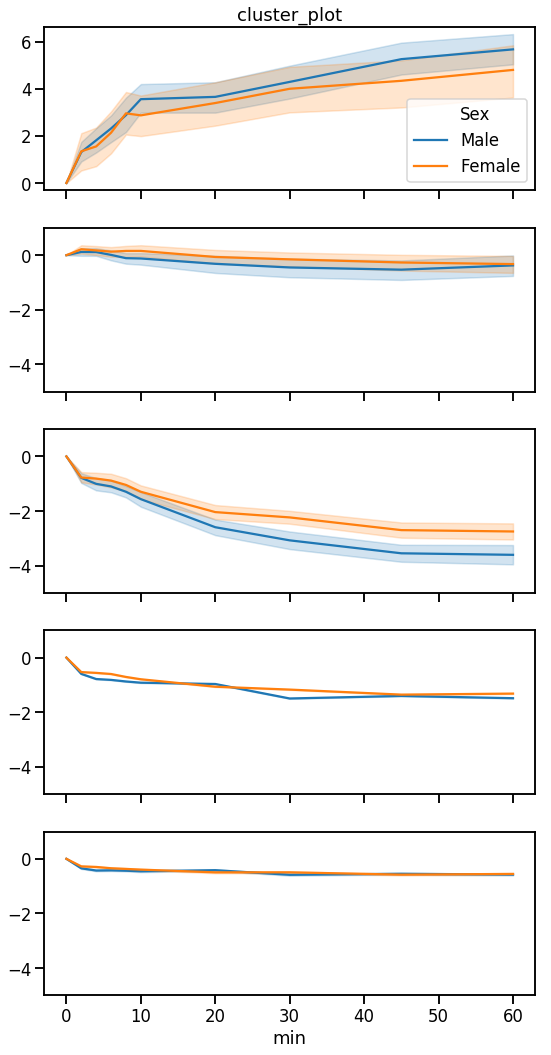

In [58]:
fig = plot_by_cluster(fc_subset,title='cluster_plot')
fig.savefig('../viz/cluster_groups/isomap_early_0.01.png',dpi=300)

In [17]:
clust_df.query('cluster_id == 1')

,Molecular_Weight,dim_1,dim_2,cluster_id,Molecular_Weight_4
3,117.99738,-0.115456,-4.013245,1,117.9974
4,203.95814,-0.116108,-3.769398,1,203.9581
5,220.97999,-0.115668,-3.946832,1,220.9800
6,253.81997,-0.115576,-3.969984,1,253.8200
7,271.94342,-0.115893,-3.870398,1,271.9434
8,369.06877,-0.115843,-3.888676,1,369.0688
9,467.81109,-0.116215,-3.737296,1,467.8111
10,468.34853,7.963662,-4.059106,1,468.3485
11,517.40038,-0.116281,-3.631062,1,517.4004
12,662.65067,-0.115521,-3.984234,1,662.6507


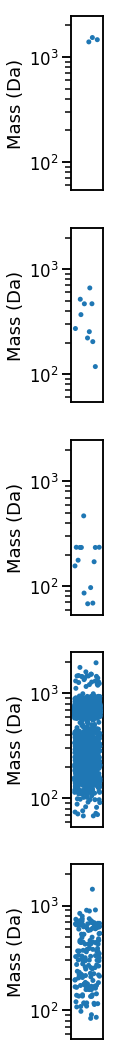

In [23]:
groups = fc_subset.cluster_id.drop_duplicates().values
num_groups = len(groups)
fig,axs = plt.subplots(num_groups,1,figsize=(2,15),sharey=True)

for clust_id,ax in zip(sorted(groups),axs):

    g = sns.stripplot(x='cluster_id',y='Molecular_Weight',data=clust_df.query('cluster_id == {}'.format(clust_id)),
                      jitter=0.4,ax=ax)
    # g.axes.yaxis.set_minor_locator(tkr.LogLocator(base=10, subs='all'))
    # g.axes.yaxis.set_minor_formatter(tkr.NullFormatter())
    g.axes.set_yscale('log')
    ax.set_xlabel('')
    ax.set_ylabel('Mass (Da)')
    ax.set_xticks([])
    

fig.tight_layout()
fig.savefig('../viz/cluster_groups/mass_by_group.png',dpi=300)

# g.ax.grid(True,which="both",ls="--",c='gray')

In [24]:
labs = np.unique(fc_subset.cluster_id.values)

/home/elijahc/.pyenv/versions/jupyterlab-gpu/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


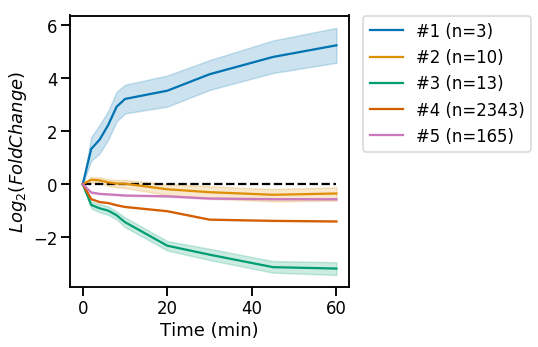

In [108]:
sns.set_context('talk')
t_split = 4
pal = sns.cubehelix_palette(5)
pal = sns.palettes.color_palette('colorblind',n_colors=5)

fig,ax = plt.subplots(1,1,figsize=(5,5),sharey=True)
g = sns.lineplot(x='min',y='log2fc',hue='cluster_id',data=fc_subset,legend='full',ax=ax,palette=pal)
ax.hlines(y=0,xmin=0,xmax=60,linestyles='dashed')
# plt.xscale('log')
# axs[0].set_xlim(0,t_split)


# sns.lineplot(x='min',y='log2fc',hue='cluster_id',data=fc_subset.query('min >= {}'.format(t_split)),legend='full',ax=axs[1])
# axs[1].set_xlim(t_split,60)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,labels=['#{} (n={})'.format(i+1,n) for i,n in zip(labs,clust_ct)])
plt.ylabel(r'$Log_{2}(FoldChange)$')
plt.xlabel('Time (min)')
fig.savefig('../viz/cluster_groups/fc_profiles_by_cluster.pdf',dpi=300)

In [88]:
d = clust_df[['Molecular_Weight','cluster_id']]
d['unity'] = 1
d.head()

/home/elijahc/.pyenv/versions/jupyterlab-gpu/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Molecular_Weight,cluster_id,unity
0,1395.56419,0,1
1,1464.65505,0,1
2,1535.69129,0,1
3,117.99738,1,1
4,203.95814,1,1


Text(0,0.5,'Mass (Da)')

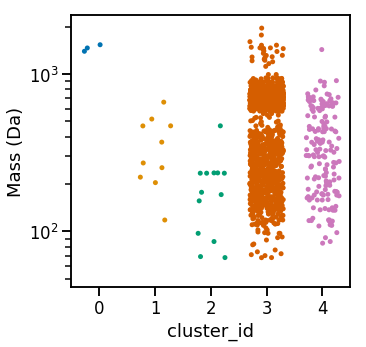

In [105]:
sns.set_context('talk')
groups = fc_subset.cluster_id.drop_duplicates().values
num_groups = len(groups)
fig,ax = plt.subplots(1,1,figsize=(5,5),sharey=True)

# ax = axs

# g = sns.FacetGrid(data=d,col='cluster_id')
sns.stripplot(x='cluster_id',y='Molecular_Weight',data=d,jitter=0.3,ax=ax,
              palette='colorblind',
             )
#     g = sns.stripplot(y='Molecular_Weight',data=clust_df.query('cluster_id == {}'.format(clust_id)),
#                       jitter=0.4,ax=ax)
#     # g.axes.yaxis.set_minor_locator(tkr.LogLocator(base=10, subs='all'))
#     # g.axes.yaxis.set_minor_formatter(tkr.NullFormatter())
ax.set_yscale('log')
#     ax.set_xlabel('')
ax.set_ylabel('Mass (Da)')
#     ax.set_xticks([])
    

# fig.tight_layout()

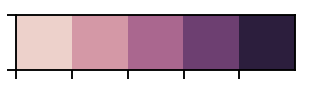

In [46]:
num_shades = 5
sns.palplot(sns.cubehelix_palette(num_shades))

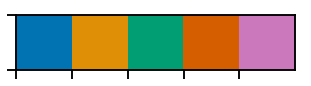

In [104]:
sns.palplot(sns.palettes.color_palette('colorblind',n_colors=5))

In [51]:
sns.cubehelix_palette(num_shades).as_hex()

['#edd1cb', '#d499a7', '#aa688f', '#6e4071', '#2d1e3e']

/home/elijahc/.pyenv/versions/jupyterlab-gpu/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


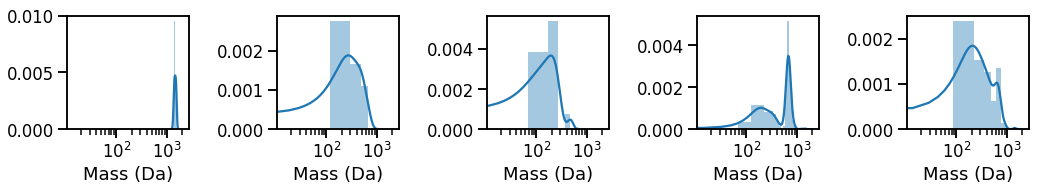

In [87]:
groups = fc_subset.cluster_id.drop_duplicates().values
num_groups = len(groups)
fig,axs = plt.subplots(1,num_groups,figsize=(15,3),sharex=True,)

for clust_id,ax in zip(sorted(groups),axs):
    d = clust_df.query('cluster_id == {}'.format(clust_id)).Molecular_Weight
#     d = clust_df[['Molecular_Weight','cluster_id']]
    g = sns.distplot(d,ax=ax,
#                      bins=10,
                    )
    # g.axes.yaxis.set_minor_locator(tkr.LogLocator(base=10, subs='all'))
    # g.axes.yaxis.set_minor_formatter(tkr.NullFormatter())
    g.axes.set_xscale('log')
#     ax.set_xlabel('')
    ax.set_xlabel('Mass (Da)')
#     ax.set_xticks([])
    

fig.tight_layout()
# fig.savefig('../viz/cluster_groups/mass_by_group.png',dpi=300)

/home/elijahc/.pyenv/versions/jupyterlab-gpu/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


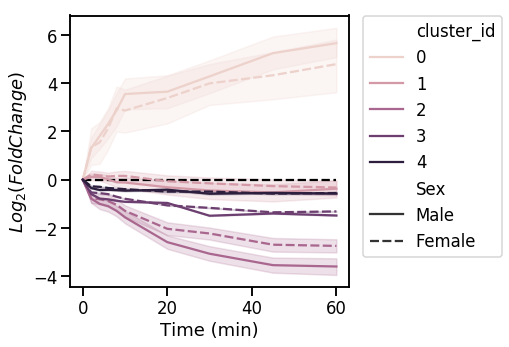

In [57]:
sns.set_context('talk');
fig,ax = plt.subplots(1,1,figsize=(5,5));
sns.lineplot(x='min',y='log2fc',hue='cluster_id',style='Sex',
             data=fc_subset,ax=ax,legend='full',err_style='band');
plt.hlines(y=0,xmin=0,xmax=60,linestyles='dashed');
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.ylabel(r'$Log_{2}(FoldChange)$');
plt.xlabel('Time (min)');

In [ ]:
fig = pairplots('Kynurenine',title='Kynurenine')
fig.savefig('../viz/mvf_timeseries/kynurenine.png',dpi=300)

In [ ]:
# metab = 'Succinate'
fig = pairplots('Succinate','Succinate')

fig.savefig('../viz/mvf_timeseries/succinate.png',dpi=300)

In [ ]:
fig = pairplots('L-Glutamate','Glutamate')
fig.savefig('../viz/mvf_timeseries/glutamate.png',dpi=300)

In [ ]:
fig = pairplots('Tryptophan',title='Tryptophan')
fig.savefig('../viz/mvf_timeseries/tryptophan.png',dpi=300)